In [1]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import (find_optimal_config,
                                         set_config)

from hybrids import ScaledHybridSVD, ScaledHybridSVDColdStart
from data_preprocessing import (get_movielens_data,
                                get_bookcrossing_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, read_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

In [2]:
from polara.recommender import defaults
defaults.memory_hard_limit = 3 # allowed memory usage during recommendations generation

In [3]:
seed = 42

In [4]:
experiment_name = 'scaledhybridsvd'

# Experiment setup

In [5]:
data_labels = ['ML1M', 'ML10M', 'BX']

In [6]:
ranks_grid = [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300,
              350, 400, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
svd_ranks = {'ML1M': [r for r in ranks_grid if r <= 1000],
             'ML10M': [r for r in ranks_grid if r <= 1000],
             'BX': [r for r in ranks_grid if r <= 2000]}
hybridsvd_weights = [0.1, 0.3, 0.5, 0.7, 0.9]

In [7]:
topk_values = [1, 3, 10, 20, 30]

In [8]:
target_metric = 'mrr'

In [9]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [10]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Movielens1M

In [11]:
lbl = 'ML1M'

In [12]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('/mnt/c/Users/evfro/Downloads/ml-1m.zip',
                                                    meta_path='data/meta_info_ml1m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [13]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [14]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Movielens10M

In [15]:
lbl = 'ML10M'

In [16]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('/mnt/c/Users/evfro/Downloads/ml-10m.zip',
                                                    meta_path='data/meta_info_ml10m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [17]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [18]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## BookCrossing

In [19]:
lbl = 'BX'

In [20]:
data_dict[lbl], meta_dict[lbl] = get_bookcrossing_data('/mnt/c/Users/evfro/Downloads/BX-CSV-Dump.zip',
                                                       get_books_meta=True,
                                                       implicit=True,
                                                       pcore=5,
                                                       filter_no_meta=True)

In [21]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [22]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [23]:
print_data_stats(data_labels, all_data)

ML1M
{'userid': 6038, 'movieid': 3522}
density 2.699052132255699
similarity matrix density 51.672185638677114
ML10M
{'userid': 69797, 'movieid': 10258}
density 0.6991397242349022
similarity matrix density 51.91219966091452
BX
{'userid': 7160, 'isbn': 16273}
density 0.18925598044812894
similarity matrix density 0.4827469267285518


# Standard experiment

In [24]:
scaling_params = {lbl: read_config('scaledsvd', lbl)['PureSVDs']['col_scaling'] for lbl in data_labels}

In [25]:
scaling_params

{'ML1M': 0.4, 'ML10M': 0.2, 'BX': 0.4}

In [26]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    svd = ScaledHybridSVD(data_model)
    svd.col_scaling = scaling_params[data_label]
    models = [svd]
    apply_config(models, config, data_label)
    return models


def fine_tune_hybridsvd(model, ranks, weights, label, record_time=False):
    model.col_scaling = scaling_params[label]
    param_grid = [(w, r) for w in weights for r in reversed(list(sorted(ranks)))]
    param_names = ('features_weight', 'rank')
    best_svd_config, svd_scores = find_optimal_config(model, param_grid, param_names,
                                                      target_metric,
                                                      return_scores=True,
                                                      force_build=False,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_svd_config))}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            max_rank = max(ranks)
            save_training_time(f'{experiment_name}_rank_{max_rank}', model, svd_scores.xs(max_rank, level='rank').index, label)
    finally:
        return model_config, model_scores

## tuning

In [27]:
config = {}
scores = {}
data_models = {}

In [28]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    config[label], scores[label] = fine_tune_hybridsvd(ScaledHybridSVD(data_models[label]),
                                                       svd_ranks[label],
                                                       hybridsvd_weights,
                                                       label, record_time=True)

 [████████████████████████████████████████████████████████████] 3/3 [01:44:47<35:54, 2095.63s/it]

           ML1M [█████████████████████████████████████████████] 100/100 [05:43<00:00, 3.43s/it]

          ML10M [█████████████████████████████████████████████] 100/100 [01:02:59<00:05, 37.79s/it]

             BX [█████████████████████████████████████████████] 120/120 [35:53<00:01, 17.94s/it]

/home/winbash/miniconda3/envs/lab/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


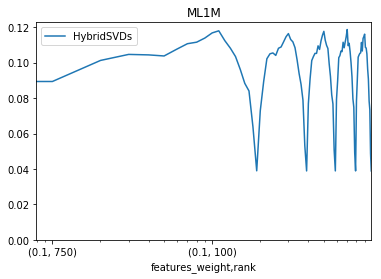

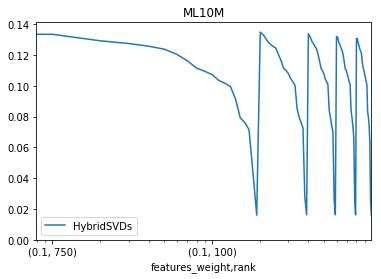

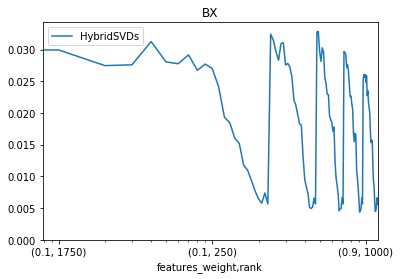

In [29]:
report_results('rank', scores);

In [30]:
config

{'ML1M': {'HybridSVDs': {'features_weight': 0.7, 'rank': 100}},
 'ML10M': {'HybridSVDs': {'features_weight': 0.1, 'rank': 1000}},
 'BX': {'HybridSVDs': {'features_weight': 0.5, 'rank': 1750}}}

### saving data

In [31]:
save_results(experiment_name, config=config, tuning=scores)

## cross-validation

In [32]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, config)
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=label))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 3/3 [01:23:22<27:12, 1667.34s/it]

           ML1M [█████████████████████████████████████████████] 5/5 [00:51<00:10, 10.11s/it]

          ML10M [█████████████████████████████████████████████] 5/5 [55:19<11:29, 663.81s/it]

             BX [█████████████████████████████████████████████] 5/5 [27:12<05:29, 326.42s/it]

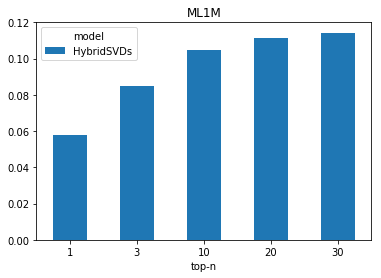

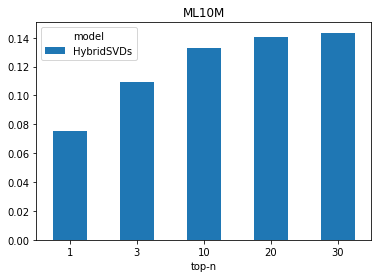

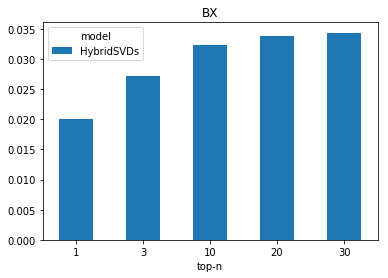

In [33]:
report_results('topn', result, target_metric);

### saving data

In [34]:
save_results(experiment_name, cv=result)

# Cold start

In [39]:
scaling_params = {lbl: read_config('scaledsvd_coldstart', lbl)['PureSVDs(cs)']['col_scaling'] for lbl in data_labels}

In [40]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    svd = ScaledHybridSVDColdStart(data_model, item_features=meta_dict[data_label])
    svd.col_scaling = scaling_params[data_label]
    models = [svd]
    for model in models:
        model.verbose = False
        model_config = config[data_label].get(model.method, None)
        if model_config:
            set_config(model, *list(zip(*model_config.items())))
    return models

## tuning

In [43]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [44]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model = ScaledHybridSVDColdStart(data_models_cold[label],
                               item_features=meta_dict[label])
    model.use_raw_features = True
    config_cold[label], scores_cold[label] = fine_tune_hybridsvd(model,
                                                                 svd_ranks[label],
                                                                 hybridsvd_weights,
                                                                 label)
    del model

 [████████████████████████████████████████████████████████████] 3/3 [01:49:10<37:42, 2183.33s/it]

           ML1M [█████████████████████████████████████████████] 100/100 [06:59<00:00, 4.19s/it]

          ML10M [█████████████████████████████████████████████] 100/100 [01:04:23<00:05, 38.63s/it]

             BX [█████████████████████████████████████████████] 120/120 [37:40<00:01, 18.84s/it]

/home/winbash/miniconda3/envs/lab/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


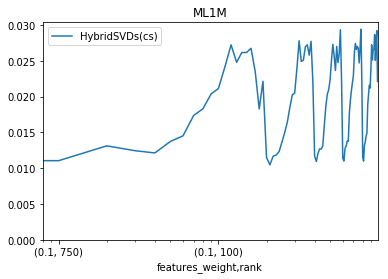

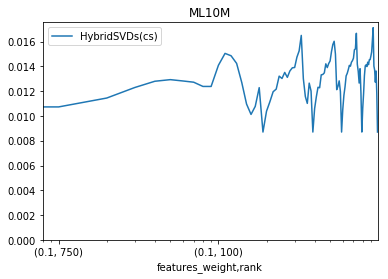

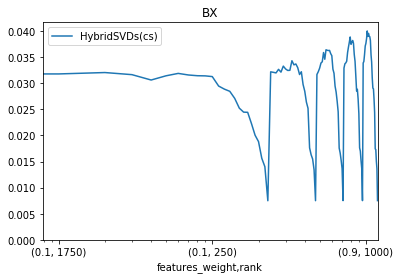

In [45]:
report_results('rank', scores_cold);

In [46]:
config_cold

{'ML1M': {'HybridSVDs(cs)': {'features_weight': 0.7, 'rank': 5}},
 'ML10M': {'HybridSVDs(cs)': {'features_weight': 0.9, 'rank': 50}},
 'BX': {'HybridSVDs(cs)': {'features_weight': 0.9, 'rank': 500}}}

### saving data

In [47]:
save_results(experiment_name+'_coldstart', config=config_cold, tuning=scores_cold)

## cross validation

In [48]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold, config_cold)
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=f'{label} folds'))

 [████████████████████████████████████████████████████████████] 3/3 [10:24<05:12, 208.11s/it]

     ML1M folds [█████████████████████████████████████████████] 5/5 [00:16<00:03, 3.11s/it]

    ML10M folds [█████████████████████████████████████████████] 5/5 [04:57<01:09, 59.34s/it]

       BX folds [█████████████████████████████████████████████] 5/5 [05:12<01:03, 62.36s/it]

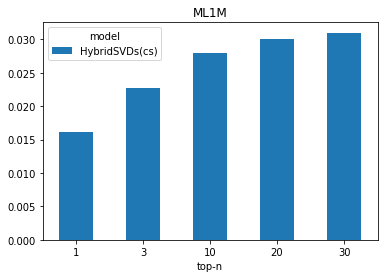

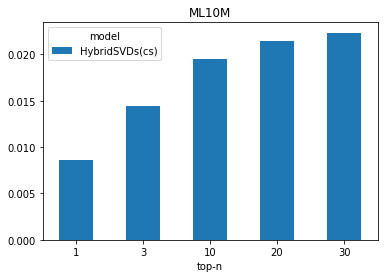

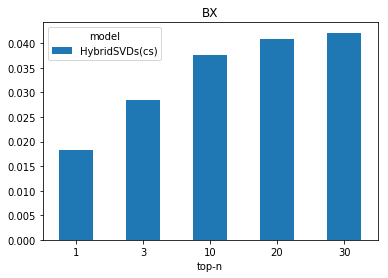

In [49]:
report_results('topn', result_cold, target_metric);

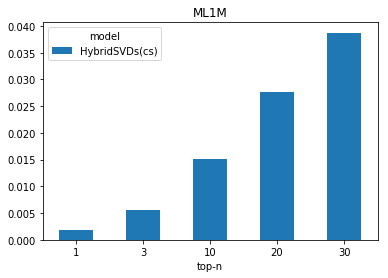

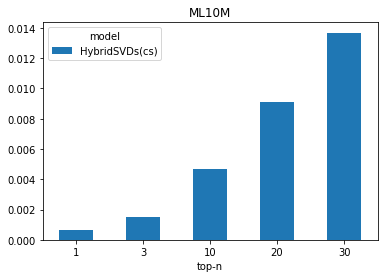

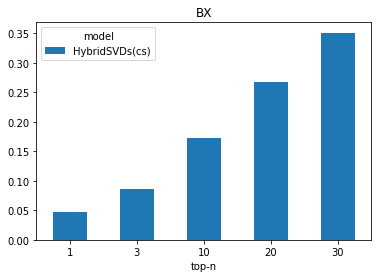

In [50]:
report_results('topn', result_cold, 'coverage');

### saving data

In [51]:
save_results(experiment_name+'_coldstart', cv=result_cold)